In [2]:
#lab-4_1

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

# 1. Завантаження та обробка датасету
file_path = './ukr.txt'  # Вкажіть шлях до датасету
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

english_sentences = []
ukrainian_sentences = []
for line in lines:
    parts = line.split('\t')
    if len(parts) >= 2:
        english_sentences.append(parts[0].strip())
        ukrainian_sentences.append(parts[1].strip())

# Додаємо спеціальні токени
start_token = '<s>'
end_token = '<e>'
ukrainian_sentences = [f"{start_token} {sentence} {end_token}" for sentence in ukrainian_sentences]

# Лімітуємо кількість даних
data_limit = 10000  # Збільшено обсяг даних
english_sentences = english_sentences[:data_limit]
ukrainian_sentences = ukrainian_sentences[:data_limit]

# Токенізація тексту
MAX_NUM_WORDS = 30000  # Збільшено розмір словника
MAX_SEQ_LENGTH = 40  # Збільшено довжину послідовностей

tokenizer_eng = Tokenizer(num_words=MAX_NUM_WORDS, filters='', lower=True)
tokenizer_ukr = Tokenizer(num_words=MAX_NUM_WORDS, filters='', lower=True)

tokenizer_eng.fit_on_texts(english_sentences)
tokenizer_ukr.fit_on_texts(ukrainian_sentences)

input_sequences = tokenizer_eng.texts_to_sequences(english_sentences)
target_sequences = tokenizer_ukr.texts_to_sequences(ukrainian_sentences)

# Паддінг
encoder_input_data = pad_sequences(input_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

# Визначаємо словники
vocab_size_eng = len(tokenizer_eng.word_index) + 1
vocab_size_ukr = len(tokenizer_ukr.word_index) + 1

# 2. Побудова моделі трансформера
EMBEDDING_DIM = 256  # Збільшено розмір ембеддингів
NUM_HEADS = 8
FF_DIM = 512
NUM_LAYERS = 6  # Збільшено кількість шарів


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position
        self.d_model = d_model

    def call(self, x):
        angle_rads = self.get_angles(
            np.arange(self.position)[:, np.newaxis],
            np.arange(self.d_model)[np.newaxis, :],
            self.d_model
        )

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return x + tf.cast(pos_encoding, tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates


# Модель трансформера

def create_transformer_model(vocab_size_enc, vocab_size_dec, seq_length):
    encoder_inputs = Input(shape=(seq_length,), name="encoder_inputs")
    decoder_inputs = Input(shape=(seq_length,), name="decoder_inputs")

    # Ембеддинг та позиційне кодування
    embedding_layer_enc = Embedding(vocab_size_enc, EMBEDDING_DIM)(encoder_inputs)
    embedding_layer_dec = Embedding(vocab_size_dec, EMBEDDING_DIM)(decoder_inputs)

    positional_encoding_enc = PositionalEncoding(seq_length, EMBEDDING_DIM)(embedding_layer_enc)
    positional_encoding_dec = PositionalEncoding(seq_length, EMBEDDING_DIM)(embedding_layer_dec)

    # Transformer layers (спрощений)
    transformer_output = Dense(EMBEDDING_DIM, activation="relu")(positional_encoding_enc)
    transformer_output = Dropout(0.2)(transformer_output)  # Збільшено Dropout
    transformer_output = LayerNormalization(epsilon=1e-6)(transformer_output)

    outputs = Dense(vocab_size_dec, activation="softmax")(transformer_output)

    return Model([encoder_inputs, decoder_inputs], outputs)


model = create_transformer_model(vocab_size_eng, vocab_size_ukr, MAX_SEQ_LENGTH)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 3. Навчання
BATCH_SIZE = 64
EPOCHS = 20  # Збільшено кількість епох

history = model.fit(
    [encoder_input_data, pad_sequences(decoder_input_data[:, :-1], maxlen=MAX_SEQ_LENGTH, padding='post')],
    pad_sequences(decoder_input_data[:, 1:], maxlen=MAX_SEQ_LENGTH, padding='post'),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# 4. Інференс
print("Навчання завершено. Модель готова до тестування!")


def beam_search_translate(input_sentence, beam_width=3):
    input_seq = tokenizer_eng.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=MAX_SEQ_LENGTH, padding='post')

    sequences = [[list(), 0.0]]  # Список послідовностей з їхніми логарифмічними ймовірностями

    for _ in range(MAX_SEQ_LENGTH):
        all_candidates = []
        for seq, score in sequences:
            decoder_seq = np.zeros((1, MAX_SEQ_LENGTH))
            for t, token in enumerate(seq):
                decoder_seq[0, t] = token

            prediction = model.predict([input_seq, decoder_seq])
            top_k = np.argsort(prediction[0, len(seq) - 1])[-beam_width:]
            for word_id in top_k:
                candidate = [seq + [word_id], score - np.log(prediction[0, len(seq) - 1, word_id])]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

        if all(seq[-1] == tokenizer_ukr.word_index[end_token] for seq, _ in sequences):
            break

    best_sequence = sequences[0][0]
    translated_sentence = ' '.join(tokenizer_ukr.index_word.get(word_id, '<unknown>') for word_id in best_sequence if
                                   word_id > 0 and word_id != tokenizer_ukr.word_index[end_token])
    return translated_sentence


# Багаторазовий переклад вручну
while True:
    user_input = input("Введіть англійське речення для перекладу (або 'exit' для виходу): ")
    if user_input.lower() == 'exit':
        print("Завершення програми.")
        break
    print("Translated:", beam_search_translate(user_input))


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.8670 - loss: 2.1903
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.9364 - loss: 0.4403
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.9401 - loss: 0.3901
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.9423 - loss: 0.3523
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.9438 - loss: 0.3180
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.9448 - loss: 0.2918
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - accuracy: 0.9468 - loss: 0.2634
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.9468 - loss: 0.2495
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.9478 - loss: 0.2336
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.9476 - loss: 0.2250
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.9487 - loss: 0.2152
Epoch 12/20
157/15

Введіть англійське речення для перекладу (або 'exit' для виходу):  Jump


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Translated: перестрибуй.


Введіть англійське речення для перекладу (або 'exit' для виходу):  I won.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Translated: я перемогли.


Введіть англійське речення для перекладу (або 'exit' для виходу):  Ask Tom


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Translated: запитай тома.


Введіть англійське речення для перекладу (або 'exit' для виходу):  Be a man


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Введіть англійське речення для перекладу (або 'exit' для виходу):  'exit'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Translated: 


Введіть англійське речення для перекладу (або 'exit' для виходу):  exit


Завершення програми.


In [2]:
#lab-4_2

import time
from transformers import pipeline

# Завантажуємо модель через Pipeline
translator = pipeline("translation_en_to_uk", model="Helsinki-NLP/opus-mt-en-uk")

# Функція для тестування точності перекладу
def test_translation_accuracy():
    print("=== Точність перекладу ===")
    texts = [
        "The cat is on the roof.",
        "Artificial intelligence is transforming the world.",
        "Kyiv is the capital of Ukraine.",
    ]
    for text in texts:
        result = translator(text, max_length=100)
        print(f"Input: {text}")
        print(f"Translated: {result[0]['translation_text']}\n")

# Функція для тестування стійкості до помилок
def test_resilience_to_errors():
    print("=== Стійкість до текстів із помилками ===")
    texts = [
        "Ths sentnce hs typos.",
        "U gonna lve this translater, it's awsm!",
        "Lets se hw this handels bad grammr.",
    ]
    for text in texts:
        result = translator(text, max_length=100)
        print(f"Input: {text}")
        print(f"Translated: {result[0]['translation_text']}\n")

# Функція для тестування швидкості роботи
def test_translation_speed():
    print("=== Швидкість роботи ===")
    texts = [
        "Short text.",
        "This is a medium-length sentence for testing translation speed.",
        "This paragraph contains multiple sentences. It is designed to test how long it takes for the model to translate a relatively long text."
    ]
    for text in texts:
        start_time = time.time()
        result = translator(text, max_length=200)
        end_time = time.time()
        print(f"Input: {text}")
        print(f"Translated: {result[0]['translation_text']}")
        print(f"Time taken: {end_time - start_time:.2f} seconds\n")

# Виконання тестів
if __name__ == "__main__":
    print("Тести продуктивності моделі перекладу:\n")
    test_translation_accuracy()
    test_resilience_to_errors()
    test_translation_speed()


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-uk.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.
Device set to use 0


Тести продуктивності моделі перекладу:

=== Точність перекладу ===
Input: The cat is on the roof.
Translated: Кіт на даху.

Input: Artificial intelligence is transforming the world.
Translated: Штучний інтелект змінює світ.

Input: Kyiv is the capital of Ukraine.
Translated: Київ - столиця України.

=== Стійкість до текстів із помилками ===
Input: Ths sentnce hs typos.
Translated: Оператори для відправки.

Input: U gonna lve this translater, it's awsm!
Translated: У мене є перекладач, це авсм!

Input: Lets se hw this handels bad grammr.
Translated: Давайте подивимось hw цей ватажк погано гомр.

=== Швидкість роботи ===
Input: Short text.
Translated: Короткий текст.
Time taken: 1.21 seconds

Input: This is a medium-length sentence for testing translation speed.
Translated: Це речення середньої довжини для перевірки швидкості перекладу.
Time taken: 1.89 seconds

Input: This paragraph contains multiple sentences. It is designed to test how long it takes for the model to translate a relati

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 361.4147 - val_loss: 260.2164
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 256.4297 - val_loss: 252.3995
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 249.5863 - val_loss: 248.1870
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 245.8312 - val_loss: 246.2672
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 244.1489 - val_loss: 245.9092
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 243.2101 - val_loss: 244.4461
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 242.2597 - val_loss: 243.6926
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 241.7220 - val_loss: 243.4347
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 240.9478 - val_loss: 242.8949
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 240.5790 - val_loss: 242.4053
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 241.0443 - val_l

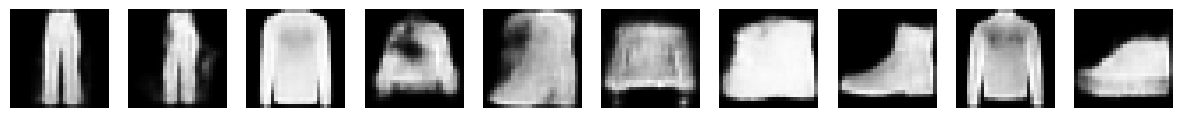

In [1]:
#lab-4_3

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Завантаження та попередня обробка датасету Fashion MNIST
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Параметри моделі
latent_dim = 16  # Розмір латентного простору
input_dim = (28, 28, 1)

# Створення енкодера
input_layer = layers.Input(shape=input_dim)
x = layers.Conv2D(32, kernel_size=3, activation='relu', strides=2, padding='same')(input_layer)
x = layers.Conv2D(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
mean = layers.Dense(latent_dim, name='latent_mean')(x)
log_variance = layers.Dense(latent_dim, name='latent_log_var')(x)

# Функція для вибірки
def reparameterization(args):
    mean, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

latent_vector = layers.Lambda(reparameterization, output_shape=(latent_dim,), name='latent_vector')([mean, log_variance])

# Створення енкодера
encoder = Model(input_layer, [mean, log_variance, latent_vector], name='Encoder')

# Створення декодера
latent_input = layers.Input(shape=(latent_dim,))
y = layers.Dense(7 * 7 * 64, activation='relu')(latent_input)
y = layers.Reshape((7, 7, 64))(y)
y = layers.Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same')(y)
y = layers.Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same')(y)
output_layer = layers.Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(y)

decoder = Model(latent_input, output_layer, name='Decoder')

# VAE з кастомним обчисленням втрат
class VariationalAutoencoder(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VariationalAutoencoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, reconstructed), axis=(1, 2))
        reconstruction_loss *= 28 * 28
        kl_divergence = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_divergence)
        self.add_loss(total_loss)
        return reconstructed

vae = VariationalAutoencoder(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(train_images, train_images, epochs=20, batch_size=128, validation_data=(test_images, test_images))

# Візуалізація результатів
def visualize_generated_images(decoder, num_images=10):
    random_latents = np.random.normal(size=(num_images, latent_dim))
    generated = decoder.predict(random_latents)
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

visualize_generated_images(decoder)